<a href="https://colab.research.google.com/github/upadhyan/STAT-598-Work/blob/main/STAT_598_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import csv
from google.colab import drive
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Problem 1


Reading in the data

In [ ]:
male_test=pd.read_csv('drive/My Drive/Colab Notebooks/HW2_ECE595/male_test_data.csv')
male_train=pd.read_csv('drive/My Drive/Colab Notebooks/HW2_ECE595/male_train_data.csv')
female_test=pd.read_csv('drive/My Drive/Colab Notebooks/HW2_ECE595/female_test_data.csv')
female_train=pd.read_csv('drive/My Drive/Colab Notebooks/HW2_ECE595/female_train_data.csv')

Printing the unmodified data

In [ ]:
female_train.female_bmi.head(10)

0    28.2
1    22.2
2    27.1
3    28.1
4    25.5
5    23.0
6    35.6
7    31.1
8    24.6
9    43.0
Name: female_bmi, dtype: float64

In [ ]:
female_train.female_stature_mm.head(10)

0    1563.0
1    1716.0
2    1484.0
3    1651.0
4    1548.0
5    1665.0
6    1564.0
7    1676.0
8    1690.0
9    1704.0
Name: female_stature_mm, dtype: float64

In [ ]:
male_train.male_bmi.head(10)

0    30.0
1    25.6
2    24.2
3    27.4
4    25.9
5    25.3
6    22.7
7    25.4
8    34.1
9    33.4
Name: male_bmi, dtype: float64

In [ ]:
male_train.male_stature_mm.head(10)

0    1679.0
1    1586.0
2    1773.0
3    1816.0
4    1809.0
5    1662.0
6    1829.0
7    1686.0
8    1761.0
9    1797.0
Name: male_stature_mm, dtype: float64

Editing the columns to make them better for cvx

In [ ]:
male_train.male_stature_mm = male_train.male_stature_mm * .001
male_test.male_stature_mm = male_test.male_stature_mm * .001
female_train.female_stature_mm = female_train.female_stature_mm * .001
female_test.female_stature_mm = female_test.female_stature_mm * .001

male_train.male_bmi = male_train.male_bmi * .1
male_test.male_bmi = male_test.male_bmi * .1
female_train.female_bmi = female_train.female_bmi *.1
female_test.female_bmi = female_test.female_bmi *.1

# Problem 2
### Data Prep


In [ ]:
y_train = np.concatenate([np.ones(len(male_train)), 
                         np.ones(len(female_train)) * -1])
y_test = np.concatenate([np.ones(len(male_test)), 
                         np.ones(len(female_test)) * -1])
labels = ['index', 'BMI', 'Stature']
male_train.columns = labels
male_test.columns = labels
female_train.columns = labels
female_test.columns = labels
X_train = pd.concat([male_train, female_train]).drop(columns = 'index')
X_test = pd.concat([male_test, female_test]).drop(columns = 'index')
X_test.insert(0,'c', np.ones(len(X_test)))
X_train.insert(0, 'c', np.ones(len(X_train)))
X_train

,c,BMI,Stature
0,1.0,3.00,1.679
1,1.0,2.56,1.586
2,1.0,2.42,1.773
3,1.0,2.74,1.816
4,1.0,2.59,1.809
...,...,...,...
1659,1.0,2.79,1.635
1660,1.0,3.14,1.655
1661,1.0,2.79,1.573
1662,1.0,2.13,1.432


### Part A:Derivation of $\hat{\theta}$
$\nabla_\theta \hat{\theta}= 0 = \nabla_\theta \mathbb{||y - X\hat{\theta}||^2}$

$0 = -2\mathbb{X}^T(\mathbb{y-X\hat{\theta}})$

$0 = -2\mathbb{X}^Ty+2\mathbb{X}^T\mathbb{X\hat{\theta}}$

$\hat{\theta} = (\mathbb{X}^T\mathbb{X})^{-1}\mathbb{X}^T\mathbb{y}$
### Part B: Implentation of A

In [ ]:
#Turn df into np array
X = np.matrix(X_train.values)
y = np.matrix(y_train).transpose()
X_t = np.transpose(X)
inv_term = np.linalg.inv(np.matmul(X_t,X))
invtimeXt = np.matmul(inv_term, X_t)
theta = np.matmul(invtimeXt, y)
theta

matrix([[-10.7017505 ],
        [ -0.12339677],
        [  6.67486843]])

### Part C: CVX Linear Model

In [ ]:
theta = cp.Variable([3,1])
objective = cp.Minimize(cp.sum_squares(X*theta - y))
prob = cp.Problem(objective, [])
prob.solve()
theta.value

array([[-10.7017505 ],
       [ -0.12339677],
       [  6.67486843]])

### Part D: Gradient Descent Derivation
$\nabla \epsilon_{train}^k = \nabla_\theta \mathbb{||y - X\theta||^2} = -2\mathbb{X}^T(\mathbb{y-X\theta})$

$d = -\nabla \epsilon_{train}^k$

$\alpha  = \frac{\nabla J(\theta)^T d}{(\mathbb{X}^T\mathbb{X}d)^Td}$

The Gradient descent equation is: 
$\theta^{k+1} = \theta^{k} + \alpha \nabla J(\theta)$

### Part E & F: Gradient Descent Implementation and Loss


In [ ]:
theta = np.zeros([3,1])
cost = []
for k in range(0,50000):
  #alpha = 0.01
  grad = -(X_t* (y - X * theta))
  d = -grad
  alpha_0 = (grad.transpose() * d) /  ((X_t * X * d).transpose() * d) 
  theta = theta + alpha_0[0,0] * grad
  cost.append(np.linalg.norm(y-X*theta)**2 / X.shape[0])
theta


matrix([[-10.7017505 ],
        [ -0.12339677],
        [  6.67486843]])

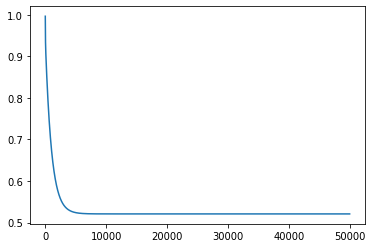

In [ ]:
plt.plot(range(0,50000), cost);

### Part G & H: Momentum Method and Loss

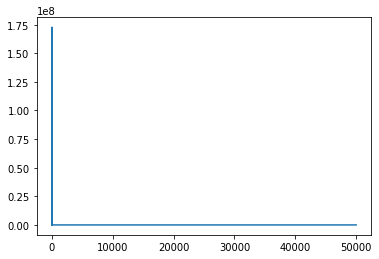

In [ ]:
theta = np.ones([3,1])
theta_back = np.ones([3,1])
grad_back = -(X_t* (y - X * theta))
beta = 0.9
cost = []
for k in range(1, 50000):
  grad = -(X_t* (y - X * theta))
  d = -grad
  alpha = (grad.transpose() * d) /  ((X_t * X * d).transpose() * d) 
  theta = theta + alpha[0,0] * (beta * grad_back + (1-beta) * grad)
  grad_back = grad
  cost.append(np.linalg.norm(y-X*theta)**2 / X.shape[0])
plt.plot(range(1,50000), cost)

# Problem 3: Visualization and Testing
### Part A

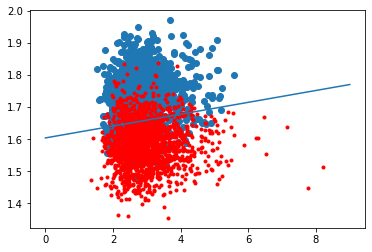

In [ ]:
plt.scatter(X_train.BMI.head(len(male_train)), X_train.Stature.head(len(male_train)), marker="o");
plt.scatter(X_train.BMI.tail(len(female_train)), X_train.Stature.tail(len(female_train)), marker=".", c="red");
#x1 = bmi
#x2 = Stature
x_2 = (-theta[0][0,0] - theta[1][0,0]*range(0,10)) / theta[2][0,0]
plt.plot(range(0,10), x_2)
plt.show()

### Part B



In [ ]:
X = np.matrix(X_test.values)
y = np.matrix(y_test).transpose()
prediction = X*theta

prediction[prediction >= 0] = 1
prediction[prediction < 0] = -1
compare_vector = y - prediction
type_1 = np.sum(compare_vector == -2) / len(compare_vector)
type_2 = np.sum(compare_vector == 2) / len(compare_vector)
print("Type 1 Error: ")
print(type_1)
print("Type 2 Error: ")
print(type_2)

Type 1 Error: 
0.07085828343313373
Type 2 Error: 
0.08982035928143713


In [ ]:
precision = precision_score(y, prediction, average='binary')
recall = recall_score(y, prediction, average='binary')
print("Precision: ")
print(precision)
print("Recall: ")
print(recall)


Precision: 
0.8526970954356846
Recall: 
0.8203592814371258


# Problem 4: Regularization
### Part A

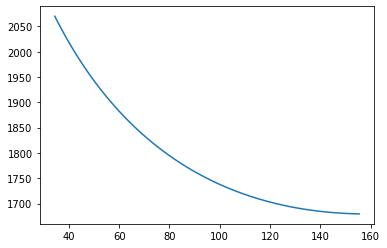

In [ ]:
X = np.matrix(X_train.values)
y = np.matrix(y_train).transpose()
lambd = np.arange(0.1,10,0.1)
loss = []
theta_val = []
for l in lambd:
  theta = cp.Variable([3,1])
  objective = cp.Minimize(cp.sum_squares(X*theta - y) + l*cp.sum_squares(theta))
  prob = cp.Problem(objective, [])
  prob.solve()
  theta = theta.value
  loss.append(np.linalg.norm(X*theta - y)**2)
  theta_val.append(np.linalg.norm(theta)**2)
theta_val = np.array(theta_val)
loss = np.array(loss)
plt.plot(theta_val, loss);

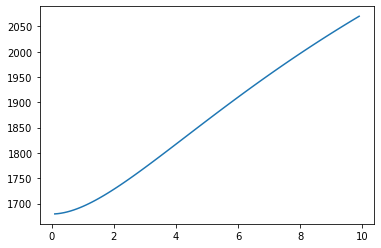

In [ ]:
plt.plot(lambd, loss);

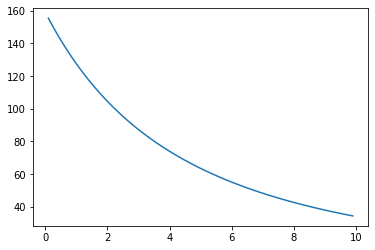

In [ ]:
plt.plot(lambd, theta_val);

### Part B

$\newcommand{\thehat}{\hat{\theta_\lambda}}
\newcommand{\loss}{||\mathbb{X}\hat{\theta_\lambda} - y||_2^2}
$
Note: $\lambda$ in this problem refers to $\lambda$***I***


*Optimization Problem 3*


The first problem has no lagrange multiplier since there are no constraints, therefore the lagrangian is the function itself. Additionally, there are no constraints, so we can assume primal feasability, therefore we need to satisfy the stationarity assumption.

$\mathcal{L}(\hat{\theta_\lambda}) = \loss + \lambda||\thehat||_2^2$

$\nabla_{\hat{\theta_\lambda}} = 2\mathbb{X}^T(\mathbb{X}
\thehat - y) + 2\lambda\thehat = 0$

$2\mathbb{X}^Ty = \thehat(2\mathbb{X}^T\mathbb{X}+2\lambda)$

$\newcommand{\soltheta}{\mathbb{X}^Ty(\mathbb{X}^T\mathbb{X}+\lambda)^{-1}}$
$\thehat = \soltheta$




*Optimization Problem 4*

At the optimal $\alpha$, $||\thehat||_2^2 < \alpha$

$\mathcal{L}(\hat{\theta_\lambda}, \gamma_\alpha) = ||\mathbb{X}\hat{\theta_\lambda} - y||_2^2 - \gamma_\alpha(\alpha - || \hat{\theta_\lambda}||_2^2 )$

$\nabla_{\hat{\theta_\lambda}}\mathcal{L}(\hat{\theta_\lambda}, \gamma_\alpha) = \gamma_\alpha\hat{\theta_\lambda} -\mathbb{X}^T(\mathbb{X\hat{\theta_\lambda}} - y) = 0$

$\nabla_{\gamma_\alpha}\mathcal{L}(\hat{\theta_\lambda}, \gamma_\epsilon) =|| \hat{\theta_\lambda}||_2^2 - \alpha = 0$

$\alpha = ||\soltheta||^2$

$\gamma_\alpha = \mathbb{X}^T(\mathbb{X}\soltheta-y)(\soltheta)^{-1}$

*Optimization Problem 5*

At the optimal $\gamma$, $||\mathbb{X}\hat{\theta_\lambda} - y||_2^2 < \gamma$

$\mathcal{L}(\hat{\theta_\lambda},\gamma_\epsilon) = || \hat{\theta_\lambda}||_2^2 - \gamma_\epsilon(\epsilon - ||\mathbb{X}\hat{\theta_\lambda} - y||_2^2)$

$\nabla_{\hat{\theta_\lambda}}\mathcal{L}(\hat{\theta_\lambda}, \gamma_\epsilon) =\thehat - \gamma_\epsilon(\mathbb{X}^T\thehat) = 0$

$\nabla_{\gamma_\epsilon}\mathcal{L}(\hat{\theta_\lambda}, \gamma_\epsilon) = ||\mathbb{X}\hat{\theta_\lambda} - y||_2^2 - \epsilon = 0$

$\epsilon = ||\mathbb{X}\soltheta - y||^2$

$\gamma_\epsilon = \soltheta(\mathbb{X}^T\soltheta)^{-1}$



**Since our gradients with respect to all variables is greater than or equal to zero for all conditions, we can say our function is convex. If a function is convex, there is only a single minimum. If we satisfy the KKT conditions, we will find the optimal solution. Since the solutions above satisfy the KKT conditions, the solutions above are optimal.**


